In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stem = "/Users/bandari/Documents/git.repos/rrlfe/"

In [3]:
# read in a 

file_name = stem + "ew_products/all_sdss_spectra_20211118_restacked_ew_info_good_only_w_net_balmer_errors.csv"

In [4]:
df = pd.read_csv(file_name)

In [5]:
df.keys()

Index(['realization_spec_file_name', 'orig_spec_file_name', 'EW_Hbeta',
       'err_EW_Hbeta_from_robo', 'EW_Hdelta', 'err_EW_Hdelta_from_robo',
       'EW_Hgamma', 'err_EW_Hgamma_from_robo', 'EW_Heps',
       'err_EW_Heps_from_robo', 'EW_CaIIK', 'err_EW_CaIIK_from_robo',
       'EW_Balmer', 'err_EW_Balmer_based_Robo',
       'err_EW_Balmer_based_noise_churning'],
      dtype='object')

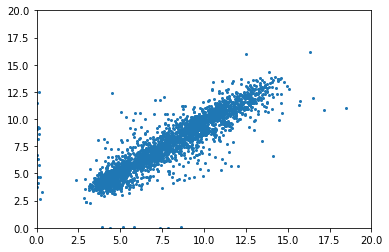

In [6]:
plt.scatter(df["EW_Hdelta"], df["EW_Hgamma"], s=4)
plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

In [7]:
# np.logical_and(df["EW_Hdelta"] > 0.5, df["EW_Hdelta"] < 20.)
# np.logical_and(df["EW_Hgamma"] > 0.5, df["EW_Hgamma"] < 20.)

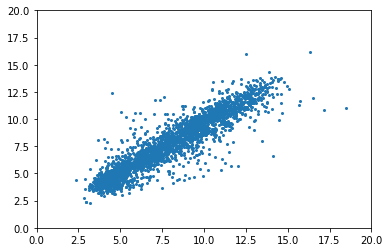

In [8]:
# get rid of really bad points

idx_cond = np.logical_and(
                        np.logical_and(df["EW_Hdelta"] > 0.5, df["EW_Hdelta"] < 20.),
                        np.logical_and(df["EW_Hgamma"] > 0.5, df["EW_Hgamma"] < 20.)
                        )

In [ ]:
plt.scatter(df["EW_Hdelta"].where(idx_cond), df["EW_Hgamma"].where(idx_cond), s=4)
plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

In [9]:
df["EW_Hdelta"].where(idx_cond).dropna()

0       10.924209
1        4.347744
2       11.430905
3        9.487499
4        8.852915
          ...    
2674    10.297540
2675    12.604587
2676     9.908558
2677     9.345149
2678     8.120021
Name: EW_Hdelta, Length: 2568, dtype: float64

In [35]:
df.keys()

Index(['realization_spec_file_name', 'orig_spec_file_name', 'EW_Hbeta',
       'err_EW_Hbeta_from_robo', 'EW_Hdelta', 'err_EW_Hdelta_from_robo',
       'EW_Hgamma', 'err_EW_Hgamma_from_robo', 'EW_Heps',
       'err_EW_Heps_from_robo', 'EW_CaIIK', 'err_EW_CaIIK_from_robo',
       'EW_Balmer', 'err_EW_Balmer_based_Robo',
       'err_EW_Balmer_based_noise_churning'],
      dtype='object')

In [36]:
W_gamma = df["EW_Hgamma"].where(idx_cond).dropna()
W_delta = df["EW_Hdelta"].where(idx_cond).dropna()
err_W_gamma = df["err_EW_Hgamma_from_robo"].where(idx_cond).dropna()
err_W_delta = df["err_EW_Hdelta_from_robo"].where(idx_cond).dropna()

In [11]:
coeff_initial, cov_initial = np.polyfit(W_delta, W_gamma, deg=1, full=False, cov=True)
m = coeff_initial[0]
b = coeff_initial[1]
err_m = np.sqrt(np.diag(cov_initial))[0]
err_b = np.sqrt(np.diag(cov_initial))[1]

In [15]:
# rescale 

In [12]:
W_gamma_prime = np.divide(np.subtract(W_gamma,b),m)

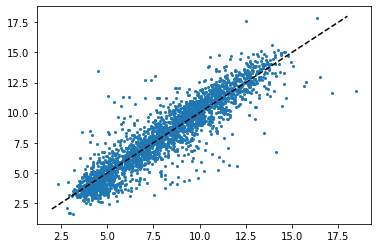

In [13]:
plt.clf()
plt.scatter(W_delta, W_gamma_prime, s=4)
plt.plot([2,18],[2,18],linestyle="--",color="k")
#plt.xlim([0,5])
#plt.ylim([0,5])
plt.show()

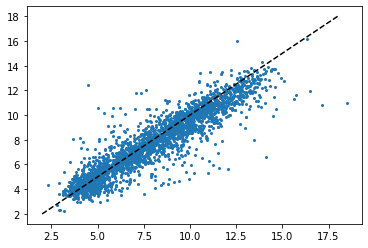

In [44]:
plt.clf()
plt.scatter(W_delta, W_gamma, s=4)
plt.plot([2,18],[2,18],linestyle="--",color="k")
#plt.xlim([0,5])
#plt.ylim([0,5])
plt.show()

In [14]:
# we can obtain the variance-covariance matrix by just fitting another line to this

coeff_scaled, cov_scaled = np.polyfit(W_delta, W_gamma_prime, deg=1, full=False, cov=True)

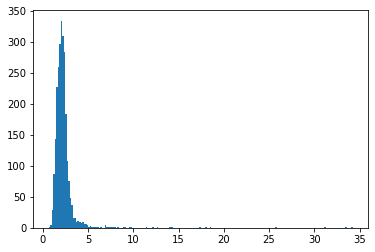

In [38]:
plt.hist(err_W_delta, bins=200)
plt.show()

In [15]:
cov_scaled

array([[ 7.09219133e-05, -5.68674231e-04],
       [-5.68674231e-04,  5.12806866e-03]])

In [17]:
cov_scaled[0,1]

-0.0005686742306283903

In [18]:
# Propagate the error in the equation
#
# W_B = (1/2)*(W_delta + W_gamma_prime)
#
# as
#
# var_B = sigma_B^2 = F_matrix * C_matrix * (F_matrix^T)
#
# where F_matrix is the Jacobian matrix and C_matrix is the variance-covariance matrix

In [19]:
# Jacobian

F_matrix = 0.5*np.matrix([[1,1]])

In [20]:
# variance-covariance matrix

C_matrix = np.copy(cov_scaled)

In [21]:
# find variance of net balmer line

var_B = np.matmul(F_matrix,np.matmul(C_matrix,F_matrix.T))

In [22]:
var_B

matrix([[0.00101541]])

In [26]:
sigma_B = np.sqrt(var_B[0,0])

In [27]:
sigma_B

0.03186550687604238

In [25]:
np.sqrt(var_B).shape

(1, 1)

In [28]:
np.sqrt(C_matrix[0,0])

0.008421514907883813

In [29]:
np.sqrt(C_matrix[1,1])

0.0716105345726555

In [30]:
# check the answer manually

var_B_manual = 0.25*(C_matrix[0,0] + C_matrix[1,1]) + 0.5*C_matrix[0,1]

In [31]:
var_B_manual

0.001015410528467104

In [32]:
np.sqrt(var_B_manual)

0.03186550687604238

In [ ]:
# ... but note that this just yields one net variance, var_B, for all the data points.
# We want an error for *each* data point, so when we find the net variance of the 
# Balmer line, use error values from a single line for var_delta and var_gamma_prime


for line_num in range(0,len(err_W_gamma)):
    C_matrix_1 = np.copy(cov_scaled) # '_1' for 'one line'; here we just want to keep the covariance terms
    C_matrix_1[0,0] = np.power(W_gamma_prime,2.)
    C_matrix_1[0,0] = np.power(err_W_delta_prime,2.)
    var_B_each_pt = np.matmul(F_matrix,np.matmul(C_matrix,F_matrix.T))


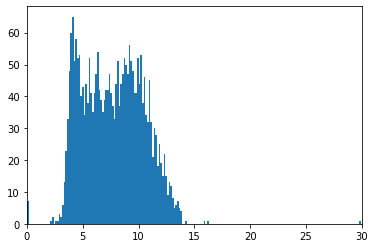

In [42]:
plt.clf()
plt.hist(df["EW_Hgamma"], bins=200)
plt.xlim([0,30])
plt.show()

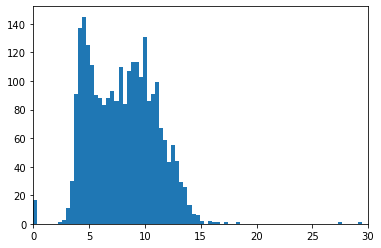

In [41]:
plt.clf()
plt.hist(df["EW_Hdelta"], bins=200)
plt.xlim([0,30])
plt.show()

In [43]:
m

0.8563900293407558

In [ ]:
df["EW_Hgamma"]